# Analyze Census Data with AI

- Use psycopg2 to load the data from the database into Python. 
- Use SQL filter the data to minimize the data transfer. 
- Use pandas and matplotlib to rocess and visualize the loaded data.
- Use OpenAI to assist coding.

### Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Modify and Query Tables with Cursor

###  Insert data
Insert a fake state with fips = 100

In [3]:
fips = '100'
name = 'fake_state'

sql_insert = f""" insert into name(fips,name)
                    values('{fips}','{name}')"""
print(sql_insert)

 insert into name(fips,name)
                    values('100','fake_state')


In [4]:
cur.execute(sql_insert)

UniqueViolation: duplicate key value violates unique constraint "name_pkey"
DETAIL:  Key (fips)=(100) already exists.


In [ ]:
conn.commit()

### Query data
Find the fake state

In [ ]:
sql_query = f"""select * from name where fips = '{fips}'"""


In [ ]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

## Rollback
When errors occur, the cursor will be locked.

The following code will generate an error

In [ ]:
cur.execute(sql_insert)

And the cursor is now locked.

In [ ]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

Unlock the cursor by using rollback

In [ ]:
conn.rollback()

Cursor is now working

In [ ]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

Delete the fake state

In [5]:
sql_delete = f"""
            delete from name
            where fips = '{fips}'
            """
print(sql_delete)


            delete from name
            where fips = '100'
            


In [6]:
cur.execute(sql_delete)

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


In [7]:
conn.commit()

The fake state is now deleted. 

In [8]:
cur.execute(sql_query)
for row in cur.fetchall():
    print(row)

NameError: name 'sql_query' is not defined

## Simple Data Analytics

### Display the VA Income Data Over Time

Define the SQL command. We filter the data based on the ```fips``` as it is a primary key.

In [9]:
sql = """
     select * from name_income
     where fips = '51'
     """

Use pandas to load the data and display the top 5 rows

In [19]:
import pandas as pd

va_df = pd.read_sql(sql, con=conn)
va_df.head() #show the top 5 rows

,fips,name,income,year
0,51,Virginia,54240,2005
1,51,Virginia,56277,2006
2,51,Virginia,59562,2007
3,51,Virginia,61233,2008
4,51,Virginia,59330,2009


Use a line chart to show the VA income over years.

<Axes: xlabel='year'>

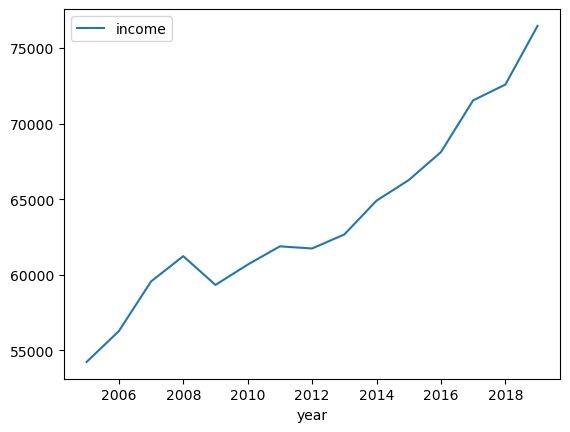

In [11]:
va_df.plot(x='year', y='income')

## Use AI to Assistant Data Analytics

### Install Python Packages

- jupyter-ai-magics: the JupyterLab AI to call Generative AI models

In [12]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [13]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [14]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands

In [15]:
%load_ext jupyter_ai_magics

Optional: Check the available AI models

`%ai list`

### Explain Existing Codes

In [16]:
%%ai gpt4
What is included in the {va_df}

The given data set includes information about the average income in the state of Virginia for each year from 2005 to 2019. 

Each row of the table represents one year and includes the following columns:

- `fips`: This column contains the Federal Information Processing Standards (FIPS) code, which is a chronological numerical code used to uniquely identify geographic locations within the United States. Here, the FIPS code '51' represents the state of Virginia.
- `name`: This column represents the name of the state for which the income data is provided. Here, all entries are 'Virginia'.
- `income`: This column indicates the average income for the state of Virginia for the respective year.
- `year`: This is the year for which the average income data is reported. In this data set, years range from 2005 to 2019.

Optional: explain a code in a specific cell with cell number

`%%ai gpt4`

`explain the code in {In[#]} `

### Create New Codes with AI

In [17]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {va_df}, use the va_df directly, and visualize the result on a line chart

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is stored in a DataFrame "va_df"

# Calculate the yearly growth rate
va_df['growth_rate'] = va_df['income'].pct_change()

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.title('Income Growth Rate in Virginia (2005 - 2019)')
plt.grid(True)
plt.show()

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe
va_df = pd.DataFrame({
    'fips': [51]*15,
    'name': ['Virginia']*15,
    'income': [54240, 56277, 59562, 61233, 59330, 60674, 61882, 61741, 62666, 64902, 66262, 68114, 71535, 72577, 76456],
    'year': list(range(2005, 2020))
})

# Calculate the growth rate
va_df['growth_rate'] = va_df['income'].pct_change()

# Plot the growth rate
plt.figure(figsize=(8,4))
plt.plot(va_df['year'], va_df['growth_rate'])
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.title('Income Growth Rate in Virginia')
plt.grid(True)
plt.show()
```
This code snippet will first create the pandas DataFrame `va_df`, and then calculate the yearly percentage change in income, which is saved as a new column 'growth_rate'. The growth rate is then plotted as a line chart with years on the x-axis and the calculated growth rate on the y-axis.

SyntaxError: invalid syntax (2183245392.py, line 23)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataframe is named as va_df

va_df['growth_rate'] = va_df['income'].pct_change() * 100

plt.figure(figsize=(8, 6))
plt.plot(va_df['year'], va_df['growth_rate'], marker='o')
plt.title('Income Growth Rate in Virginia (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

### A Complete Analysis with AI

Load the data from database into Python

In [ ]:
%%ai gpt4 -f code
We have a view named name_income in an SQL database
You don't need to redefine the connection string
use the {conn} defined in {In[2]} to load all the recored into pandas dataframe 

In [ ]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

query = "SELECT * FROM name_income"
df = pd.read_sql(query, con=conn)

conn.close()

In [ ]:
import pandas as pd

# Execute the SQL query
cur.execute("SELECT * FROM name_income")

# Fetch all the records
rows = cur.fetchall()

# Get the column names for the dataframe
column_names = [desc[0] for desc in cur.description]

# Create a pandas dataframe
df = pd.DataFrame(rows, columns=column_names)

df.head()

In [ ]:
%%ai gpt4 
What is the information in {df}

In [ ]:
%%ai gpt4 -f code
Calculate the average year-over-year income growth rate for each state in {df} 
and create a chart to show the result

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Eliminate the rows with null income
df = df.dropna(subset=['income'])

# Sort the values based on 'name' and 'year'
df = df.sort_values(['name', 'year'])

# Group the data by 'name' and calculate the income growth rate
df['income_growth'] = df.groupby('name')['income'].pct_change()*100

# Group the data by 'name' and calculate the mean of income growth
average_growth = df.groupby('name')['income_growth'].mean().reset_index()

# Plot the result
plt.figure(figsize=(10,6))

# Due to large number of states, select top 10 states with highest growth for clear visualization
top_10 = average_growth.sort_values('income_growth',ascending=False).head(10)

plt.barh(top_10['name'], top_10['income_growth'], color = 'skyblue')

plt.xlabel('Average Year-over-Year Income Growth Rate (%)')
plt.ylabel('State')
plt.title('Average Year-over-Year Income Growth Rate for Each State')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named df
df['income'] = df['income'].astype(float)
df['year'] = df['year'].astype(int)

# Group by state and calculate the average annual growth rate
df = df.sort_values(['name', 'year'])
df['income_growth'] = df.groupby('name')['income'].pct_change() + 1
df = df.groupby('name')['income_growth'].agg('mean') - 1

# Create a bar chart
df.sort_values().plot(kind='barh', figsize=(10, 20), color='skyblue')

plt.title('Average Year-Over-Year Income Growth Rate by State')
plt.xlabel('Average Year-Over-Year Growth Rate')
plt.ylabel('State')

plt.show()
'''
This Python code first converts the 'income' and 'year' columns to float and int data types, respectively. Then it sorts the DataFrame by 'name' and 'year', calculates the year-over-year income growth rate for each state and stores the result in the 'income_growth' column. The code then calculates the average income growth rate for each state and stores the result in the same DataFrame. Finally, the code creates a horizontal bar chart with the average income growth rate on the x-axis and the state on the y-axis. The chart is sorted in ascending order of growth rate.
'''

## Close Database Connection

In [ ]:
#run the folloiwng code if the connection is not closed

cur.close()
conn.close()